In [44]:
import pandas as pd
import numpy as np
from utils import spliter
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [45]:
data = pd.read_csv('utils/filtered_CNN_features_dataset.csv')
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,0,0.266585,1.337187,1.352905,0.100848,1.880685,0.059888,2.773605,0.115643,0.138749,...,0.039434,0.071662,0.733759,1.643910,0.041306,1.488236,0.048181,0.247783,0.300232,Paul_Bremer
1,1,0.355948,0.750634,0.909794,0.188214,0.680066,0.221442,3.089571,0.342022,0.087186,...,0.093867,0.089694,0.859610,1.764073,0.250430,1.133540,0.004091,0.153542,0.236034,Paul_Bremer
2,2,0.267111,1.015316,1.154480,0.131544,1.066389,0.024949,3.701925,0.145037,0.082419,...,0.080086,0.089589,0.663708,1.854499,0.078751,1.240009,0.065222,0.105058,0.227633,Paul_Bremer
3,3,0.260295,0.882900,0.885955,0.106698,2.663052,0.057836,1.854394,0.209269,0.103750,...,0.181255,0.182038,0.397535,1.222931,0.007285,0.878194,0.016247,0.110492,0.129523,Paul_Bremer
4,4,0.347203,0.623839,0.817085,0.212599,1.026321,0.176634,2.486715,0.426571,0.345026,...,0.267895,0.136346,0.713298,0.978184,0.059828,1.008205,0.042905,0.028597,0.199120,Paul_Bremer


In [46]:
data = data.drop(columns=['Unnamed: 0'])
data.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,0.266585,1.337187,1.352905,0.100848,1.880685,0.059888,2.773605,0.115643,0.138749,0.056121,...,0.039434,0.071662,0.733759,1.643910,0.041306,1.488236,0.048181,0.247783,0.300232,Paul_Bremer
1,0.355948,0.750634,0.909794,0.188214,0.680066,0.221442,3.089571,0.342022,0.087186,0.234741,...,0.093867,0.089694,0.859610,1.764073,0.250430,1.133540,0.004091,0.153542,0.236034,Paul_Bremer
2,0.267111,1.015316,1.154480,0.131544,1.066389,0.024949,3.701925,0.145037,0.082419,0.253356,...,0.080086,0.089589,0.663708,1.854499,0.078751,1.240009,0.065222,0.105058,0.227633,Paul_Bremer
3,0.260295,0.882900,0.885955,0.106698,2.663052,0.057836,1.854394,0.209269,0.103750,0.149302,...,0.181255,0.182038,0.397535,1.222931,0.007285,0.878194,0.016247,0.110492,0.129523,Paul_Bremer
4,0.347203,0.623839,0.817085,0.212599,1.026321,0.176634,2.486715,0.426571,0.345026,0.375072,...,0.267895,0.136346,0.713298,0.978184,0.059828,1.008205,0.042905,0.028597,0.199120,Paul_Bremer


In [47]:
data.shape

(4324, 2049)

In [48]:
label_encoder = LabelEncoder()
data['2048'] = label_encoder.fit_transform(data['2048'])

In [49]:
x_train, x_test, y_train, y_test = spliter.train_test_spliter(data, target_col='2048', train_size = 0.8)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

/home/mayank/all_work/ML-DL/Face_Identification/Face_Detection/applying_ML_algorithms/utils/spliter.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train = pd.concat([train, train_subset])
/home/mayank/all_work/ML-DL/Face_Identification/Face_Detection/applying_ML_algorithms/utils/spliter.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test = pd.concat([test, test_subset])


((3397, 2048), (927, 2048), (3397,), (927,))

# Using PyTorch for ANN

In [50]:
class ANN(nn.Module):
    def __init__(self, input_size, num_classes, dropout = 0):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.fc3(x)

        return x

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [70]:
input_size = x_train.shape[1]
num_classes = len(data['2048'].unique()) ##Total number of classes or labels
epochs = 100
batch_size = 64
learning_rate = 0.005
dropout = 0

### ANN on CNN_features

In [71]:
model = ANN(input_size = input_size, num_classes = num_classes, dropout=dropout).to(device)

In [54]:
train_loader = DataLoader(dataset = list(zip(x_train, y_train)), batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = list(zip(x_test, y_test)), batch_size = batch_size, shuffle = False)

In [72]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [73]:
train_acc = []
test_acc = []

for epoch in range(epochs):

    ## Training the model
    for batch_idx, (data_batch, targets) in enumerate(train_loader):
        
        ## Loading data to device available
        data_batch = data_batch.to(device = device).float()
        targets = targets.to(device = device).long()

        ## Doing the forward propagation
        scores = model(data_batch)
        loss_value = loss(scores, targets)

        ## Doing the backward propagation
        optimizer.zero_grad()
        loss_value.backward()

        ## Optimizer step
        optimizer.step()

    print(f"At epoch {epoch+1}/{epochs}:-")
    num_correct = num_samples = 0

    ## Train accuracy
    for batch_idx, (data_batch, targets) in enumerate(train_loader):
        
        ## Loading data to device available
        data_batch = data_batch.to(device = device).float()
        targets = targets.to(device = device).long()

        ## Doing the forward propagation
        scores = model(data_batch)
        
        _, predictions = scores.max(1)

        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)

    print(f"Train accuracy = {float(num_correct)/float(num_samples)*100}")
    train_acc.append(float(num_correct)/float(num_samples)*100)

    num_correct = num_samples = 0
    ## Test accuracy
    for batch_idx, (data_batch, targets) in enumerate(test_loader):
        
        ## Loading data to device available
        data_batch = data_batch.to(device = device).float()
        targets = targets.to(device = device).long()

        ## Doing the forward propagation
        scores = model(data_batch)
        
        _, predictions = scores.max(1)

        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)

    print(f"Test accuracy = {float(num_correct)/float(num_samples)*100}")
    test_acc.append(float(num_correct)/float(num_samples)*100)

At epoch 1/100:-
Train accuracy = 14.395054459817485
Test accuracy = 13.052858683926646
At epoch 2/100:-
Train accuracy = 15.366499852811305
Test accuracy = 14.347357065803667
At epoch 3/100:-
Train accuracy = 20.930232558139537
Test accuracy = 18.878101402373247
At epoch 4/100:-
Train accuracy = 21.312923167500735
Test accuracy = 18.985976267529665
At epoch 5/100:-
Train accuracy = 26.96496909037386
Test accuracy = 22.653721682847898
At epoch 6/100:-
Train accuracy = 29.584927877539002
Test accuracy = 25.13484358144552
At epoch 7/100:-
Train accuracy = 33.5884604062408
Test accuracy = 27.615965480043148
At epoch 8/100:-
Train accuracy = 34.3538416249632
Test accuracy = 26.968716289104638
At epoch 9/100:-
Train accuracy = 27.229908743008536
Test accuracy = 23.408845738942826
At epoch 10/100:-
Train accuracy = 35.14866058286724
Test accuracy = 26.321467098166128
At epoch 11/100:-
Train accuracy = 38.916691198115984
Test accuracy = 29.449838187702266
At epoch 12/100:-
Train accuracy = 44

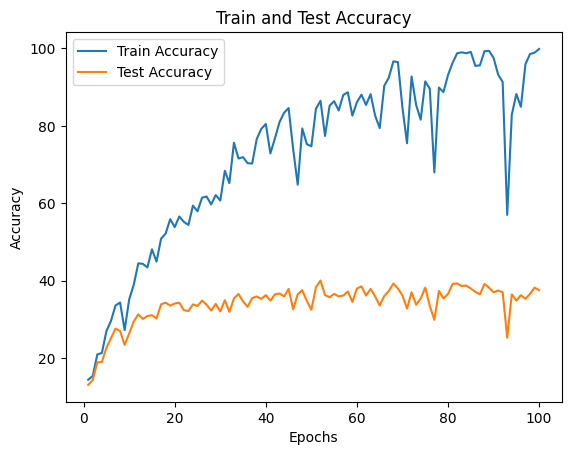

In [74]:
plt.plot(range(1, epochs + 1), train_acc, label = "Train Accuracy")
plt.plot(range(1, epochs + 1), test_acc, label = "Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy")
plt.legend()
plt.show()